# (Generalized) Pattern Lattice Builder (PLB) runner

developed by Kow Kuroda (kow.kuroda@gmail.com)

created on 2024/10/18

modified on 2024/10/20, 21, 22, 23, 26, 27, 29, 30, 31

modifications
1. added compatibility with package format (2024/10/20)
2. implemented automatic figure sizing (2024/10/22)
3. implemented robust z-score (2024/10/23)
4. implemetend multiprocess-based speeding up at PatternLattice.merge_lattices()
5. implemented content tracking (2024/10/31)
6. added upper-bound to z-score-based node pruning (2024/11/01)

In [1]:
## imports
import gPLB as plb

## The following needs to be True only for debugging/development.
re_import_module = True
if re_import_module:
    import importlib
    importlib.reload (plb)

In [2]:
## inspect plb.py
import pprint as pp
content_check = False
if content_check:
    pp.pprint(dir(plb))

In [3]:
## Parameters
## managemental
verbose     = True

## settings for CJK font display
## N.B. phonetic symbols are likely to be incompatible with CJK-ready font
use_multibyte_chars = True

## internal variables
comment_escape  = '#'
field_sep       = r","

## size filtering on input
size_filtering  = True
max_size        = 5

## parameters for PLB
gap_marks      = [ "…", "_" ]
gap_mark       = gap_marks[0]

## if Generalized Pattern Lattice is used nor not
generalized     = True

## if instantiation check is reflexive
reflexive       = True

## if node pooling is reductive
reductive       = True

## if robust Z-score is used instead of normal Z-score
use_robust_zscore   = True

## select the bases of z-scores: link sources or link targets
zscores_from_targets = False

### settings for drawing
## draw individual lattices
draw_individual_lattices   = True
draw_sample_lattices_only  = True
sample_lattice_n           = 3

## full display for merged pattern lattice
draw_full_version_for_merged = False

In [4]:
## graph layout selection
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'ARF', # 2
                    'Fruchterman_Reingold', # 3
                    'Kamada_Kawai', # 4
                    'Spring', # 5
                    'Planar', # 6
                    'Circular', # 7
                    'Shell', # 8
                    'Planar', # 9 [often fails to work]
                    # 'Breadth-First Search', # fails work
                 ]
#
graph_layout = graph_layouts[0]
print(f"graph_layout: {graph_layout}")

graph_layout: Multi_partite


In [5]:
## set up font
import matplotlib
from matplotlib import font_manager as Font_manager

if use_multibyte_chars:
    ## select font
    multibyte_font_names = [    "IPAexGothic",  # 0 Multi-platform font
                                "Hiragino sans" # 1 Mac only
                            ]
    multibyte_font_name  = multibyte_font_names[0]
    ## tell where target fonts are
    system_font_dir = "/System/Library/Fonts/"
    user_font_dir = "/Library/Fonts/"
    # use the version installed via TeXLive
    user_font_dir2 = "/usr/local/texlive/2013/texmf-dist/fonts/truetype/public/ipaex/"
    if multibyte_font_name == "IPAexGothic":
        try:
            Font_manager.fontManager.addfont(f"{user_font_dir}ipaexg.ttf")
        except FileNotFoundError:
            Font_manager.fontManager.addfont(f"{user_font_dir2}ipaexg.ttf")
    elif multibyte_font_name == "Hiragino sans":
        Font_manager.fontManager.addfont(f"{system_font_dir}ヒラギノ角ゴシック W0.ttc")
    ## check result
    matplotlib.rc('font', family = multibyte_font_name)
else:
    multibyte_font_name = None
    matplotlib.rcParams['font.family'] = "Sans-serif"
##
print(f"multibyte_font_name: {multibyte_font_name}")
print(f"matplotlib.rcParams['font.family']: {matplotlib.rcParams['font.family']}")    

multibyte_font_name: IPAexGothic
matplotlib.rcParams['font.family']: ['IPAexGothic']


# Preparation

In [6]:
## select target file
import csv
data_dir = "data"
data_names = [  'plb-sample0', 'plb-sample1', 'plb-sample2',
                'plb-inteY-max9', 'plb-inteY-max11',
                'plb-utau-naku-sinu', 'plb-utau-naku-sinu-commented',
                'plb-XiY-max7', 'plb-XiY-max9', 'plb-XiY-wiper2-phonetic', 'plb-XiY-wiper2b', 'plb-XiY-wiper3-dual','plb-XiY-wiper5b-dual'
            ]

data_name = data_names[2]
data_file = f"{data_dir}/{data_name}.csv"
print(f"read data from: {data_file}")

read data from: data/plb-sample2.csv


In [7]:
## reading data
with open(data_file, encoding = "utf-8") as file:
    data = list(csv.reader(file, delimiter = field_sep)) # Crucially list(..)

## discard comment lines that start with #
data = [ F for F in data if len(F) > 0 and not F[0][0] == comment_escape ]

## strip extra spaces
data = [ [ f.strip() for f in F ] for F in data ]

## remove in-line comments
data_renewed = [ ]
for F in data:
    G = []
    for f in F:
        pos = f.find(comment_escape)
        if pos > 0:
            G.append(f[:pos])
            continue
        else:
            G.append(f)
    ##
    data_renewed.append(G)
##
data = data_renewed

In [8]:
## check result
import pprint as pp
pp.pprint(data)

[['i', 'n'],
 ['i', 'n', 'g'],
 ['p', 'i', 'n'],
 ['p', 'i', 'n', 'k'],
 ['p', 'i', 'n', 'k', 'y'],
 ['p', 'i', 'n', 'g'],
 ['s', 'i', 'n'],
 ['s', 'i', 'n', 'k'],
 ['s', 'i', 'n', 'g'],
 ['k', 'i', 'n'],
 ['k', 'i', 'n', 'g'],
 ['k', 'i', 'n', 'k'],
 ['k', 'i', 'n', 'k', 'y'],
 ['w', 'i', 'n'],
 ['w', 'i', 'n', 'k'],
 ['w', 'i', 'n', 'k', 'y'],
 ['w', 'i', 'n', 'g'],
 ['f', 'u', 'n'],
 ['f', 'u', 'n', 'k'],
 ['f', 'u', 'n', 'k', 'y'],
 ['f', 'u', 'n', 'n', 'y'],
 ['p', 'u', 'n'],
 ['p', 'u', 'n', 'k'],
 ['d', 'u', 'n', 'k'],
 ['f', 'a', 'n'],
 ['f', 'a', 'n', 'g'],
 ['f', 'a', 'm', 'e'],
 ['f', 'a', 'm', 'o', 'u', 's'],
 ['l', 'a', 'n', 'e'],
 ['l', 'a', 'm', 'b'],
 ['b', 'u', 'm'],
 ['b', 'u', 'd'],
 ['b', 'u', 'd', 's'],
 ['b', 'u', 'd', 'd', 'y'],
 ['m', 'u', 'd'],
 ['m', 'u', 'd', 'd', 'y'],
 ['b', 'u', 'n'],
 ['b', 'u', 'n', 'n', 'y'],
 ['b', 'u', 'n', 'n'],
 ['d', 'u', 'n'],
 ['b', 'u', 'm', 'p'],
 ['b', 'u', 'm', 'p', 'y'],
 ['d', 'u', 'm', 'b']]


# Process individual pattern lattices

In [9]:
## size filter
if size_filtering and not max_size is None:
    data = [ x for x in data if len(x) <= max_size ]

In [10]:
## sampling
sampling      = True
sampling_rate = 0.3
if sampling:
      import random
      data = random.sample(data, round(len(data) * sampling_rate))
##
print(f"sampled {len(data)} inputs")
pp.pprint(data)

sampled 13 inputs
[['d', 'u', 'm', 'b'],
 ['b', 'u', 'n'],
 ['d', 'u', 'n'],
 ['d', 'u', 'n', 'k'],
 ['f', 'a', 'm', 'e'],
 ['b', 'u', 'n', 'n', 'y'],
 ['f', 'a', 'n', 'g'],
 ['p', 'i', 'n', 'g'],
 ['f', 'u', 'n', 'k'],
 ['p', 'i', 'n'],
 ['b', 'u', 'd'],
 ['b', 'u', 'm', 'p', 'y'],
 ['p', 'i', 'n', 'k', 'y']]


In [11]:
## build pattern lattices from data
Lx = [ ]
for item in data:
    pat    = plb.Pattern(item, gap_mark)
    patlat = plb.PatternLattice(pat, reflexive = reflexive, generalized = generalized)
    if verbose:
            print(patlat)
    Lx.append(patlat)
print(f"Lx contains {len(Lx)} lattices")

PatternLattice ([Pattern ([('d', ['d']), ('u', ['u']), ('m', ['m']), ('b', ['b'])]), Pattern ([('d', ['d']), ('u', ['u']), ('m', ['m']), ('b', ['b']), ('…', ['#'])]), Pattern ([('d', ['d']), ('u', ['u']), ('m', ['m']), ('…', ['b'])]), Pattern ([('d', ['d']), ('u', ['u']), ('m', ['m']), ('…', ['b']), ('…', ['#'])]), Pattern ([('d', ['d']), ('u', ['u']), ('…', ['m']), ('b', ['b'])]), Pattern ([('d', ['d']), ('u', ['u']), ('…', ['m']), ('b', ['b']), ('…', ['#'])]), Pattern ([('d', ['d']), ('u', ['u']), ('…', ['m']), ('…', ['b'])]), Pattern ([('d', ['d']), ('u', ['u']), ('…', ['m']), ('…', ['b']), ('…', ['#'])]), Pattern ([('d', ['d']), ('…', ['u']), ('m', ['m']), ('b', ['b'])]), Pattern ([('d', ['d']), ('…', ['u']), ('m', ['m']), ('b', ['b']), ('…', ['#'])]), Pattern ([('d', ['d']), ('…', ['u']), ('m', ['m']), ('…', ['b'])]), Pattern ([('d', ['d']), ('…', ['u']), ('m', ['m']), ('…', ['b']), ('…', ['#'])]), Pattern ([('d', ['d']), ('…', ['u']), ('…', ['m']), ('b', ['b'])]), Pattern ([('d',

#pruned 0 nodes
Layout is unknown: Multi-partite (default) is used
#fig_size_local: (10, 14.0)
#font_size: 7
#node_size: 12
#instance_labels 1: ['d,u,n,k']


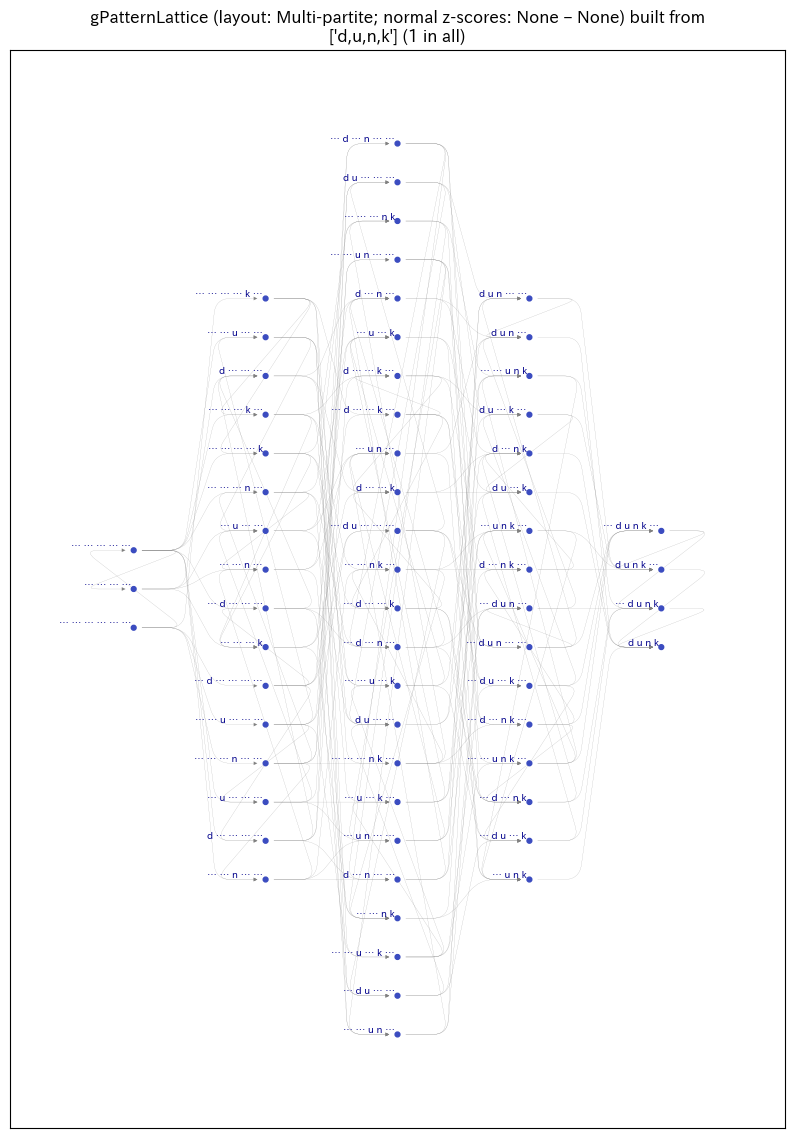

#pruned 0 nodes
Layout is unknown: Multi-partite (default) is used
#fig_size_local: (12, 14.0)
#font_size: 7
#node_size: 12
#instance_labels 1: ['b,u,n,n,y']


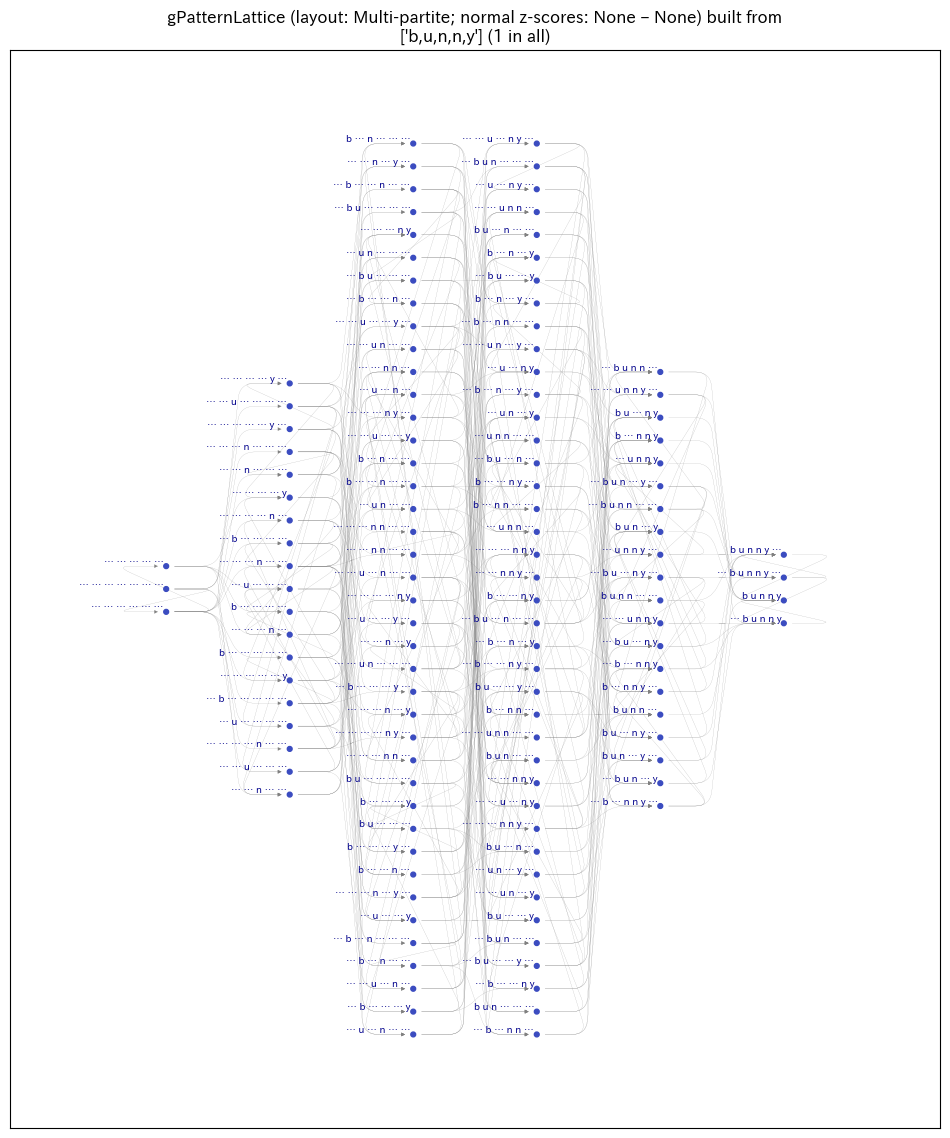

#pruned 0 nodes
Layout is unknown: Multi-partite (default) is used
#fig_size_local: (8, 14.0)
#font_size: 7
#node_size: 12
#instance_labels 1: ['b,u,d']


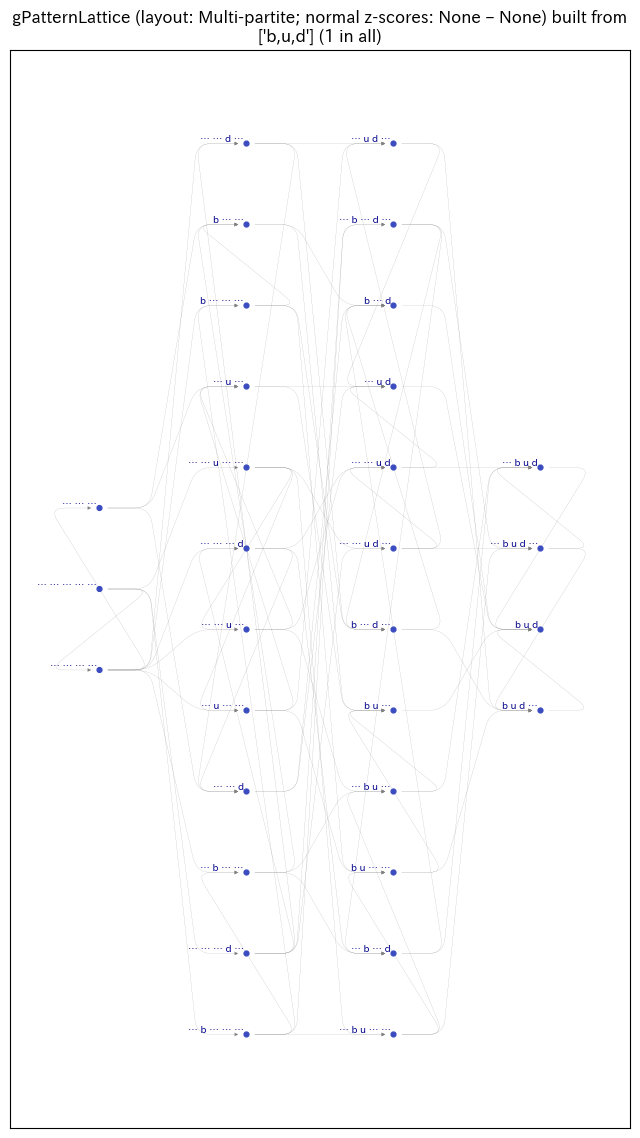

In [12]:
## draw pattern lattices individually
if draw_individual_lattices:
    if draw_sample_lattices_only:
        Ly = random.sample(Lx, sample_lattice_n)
        for patlat in Ly:
            patlat.draw_diagrams (generalized = generalized, zscores_from_targets = zscores_from_targets, auto_fig_sizing = True, font_name = multibyte_font_name)
else:
    for patlat in Lx:
        patlat.draw_diagrams (generalized = generalized, zscores_from_targets = zscores_from_targets, auto_fig_sizing = True,
                              font_name = multibyte_font_name)

In [13]:
#raise "Stop execution"

# Process merged pattern lattice

In [14]:
## merge pattern lattices
gen_links_internally = False
import functools
M = functools.reduce (lambda La, Lb: La.merge_lattices (Lb, gen_links_internally = gen_links_internally, generalized = generalized, reflexive = reflexive, reductive = reductive, use_mp = True, check = False),
                                                        Lx)

In [15]:
print(M.links)
print(f"M.links has {len(M.links)} links" )

[]
M.links has 0 links


In [16]:
## generate links: the following process was isolated for memory conservation
if not gen_links_internally and len(M.links) == 0:
    M.update_links (reflexive = reflexive, check = False)

In [17]:
## calculate z-scores from link sources
if verbose:
    print(f"##Link_sources")
    
Link_sources     = M.link_sources
ranked_links     = plb.make_ranked_dict (Link_sources, gap_mark = gap_mark)
averages_by_rank = plb.calc_averages_by_rank (Link_sources, ranked_links) # returns dict
stdevs_by_rank   = plb.calc_stdevs_by_rank (Link_sources, ranked_links) # returns dict
medians_by_rank  = plb.calc_medians_by_rank (Link_sources, ranked_links) # returns dict
MADs_by_rank     = plb.calc_MADs_by_rank (Link_sources, ranked_links) # returns dict

## calculate z-scores
source_zscores = { }
robust_zscores_from_s   = [ ] # for inspection only
normal_zscores_from_s   = [ ] # for inspection only
for i, link_source in enumerate(Link_sources):
    rank     = plb.get_rank_of_list (link_source, gap_mark)
    value    = M.link_sources[link_source]
    
    ## robust z-scores
    robust_zscore  = plb.calc_zscore (value, averages_by_rank[rank], stdevs_by_rank[rank], medians_by_rank[rank], MADs_by_rank[rank], robust = True)
    robust_zscores_from_s.append(robust_zscore)
    
    ## normal z-scores
    normal_zscore   = plb.calc_zscore_old (value, averages_by_rank[rank], stdevs_by_rank[rank])
    normal_zscores_from_s.append(normal_zscore)

    if use_robust_zscore:
        source_zscores[link_source] = robust_zscore
    else:
        source_zscores[link_source] = normal_zscore
    if verbose:
        print(f"#source {i:4d}: {link_source} has {value} out-going(s) [{source_zscores[link_source]: .4f} at rank {rank}]")
    
## attach source_zscores to M
M.source_zscores.update(source_zscores)

##Link_sources
#source    0: ('…', '…', '…') has 7 out-going(s) [-1.2647 at rank 0]
#source    1: ('b', '…', '…') has 3 out-going(s) [-1.0117 at rank 1]
#source    2: ('…', 'u', '…') has 4 out-going(s) [-0.6745 at rank 1]
#source    3: ('…', '…', 'n') has 5 out-going(s) [-0.3372 at rank 1]
#source    4: ('d', '…', '…') has 2 out-going(s) [-1.3490 at rank 1]
#source    5: ('p', '…', '…') has 2 out-going(s) [-1.3490 at rank 1]
#source    6: ('…', 'i', '…') has 2 out-going(s) [-1.3490 at rank 1]
#source    7: ('…', '…', 'd') has 2 out-going(s) [-1.3490 at rank 1]
#source    8: ('b', 'u', '…') has 2 out-going(s) [-1.3490 at rank 2]
#source    9: ('b', '…', 'n') has 1 out-going(s) [-2.0235 at rank 2]
#source   10: ('…', 'u', 'n') has 2 out-going(s) [-1.3490 at rank 2]
#source   11: ('d', 'u', '…') has 2 out-going(s) [-1.3490 at rank 2]
#source   12: ('d', '…', 'n') has 1 out-going(s) [-2.0235 at rank 2]
#source   13: ('…', 'u', 'd') has 2 out-going(s) [-1.3490 at rank 2]
#source   14: ('p',

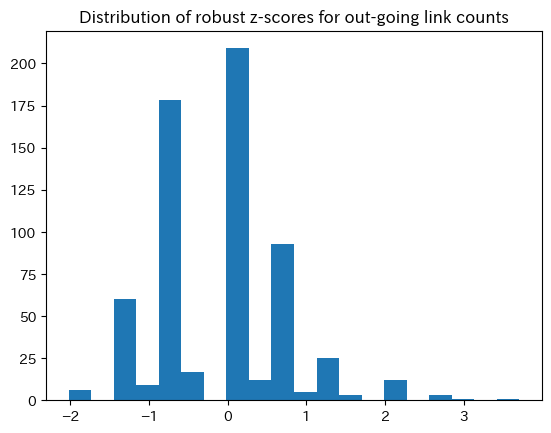

In [18]:
## check robust z-score distribution
import matplotlib.pyplot as plt
plt.hist(robust_zscores_from_s, bins = 20)
plt.title(f"Distribution of robust z-scores for out-going link counts")
plt.show()

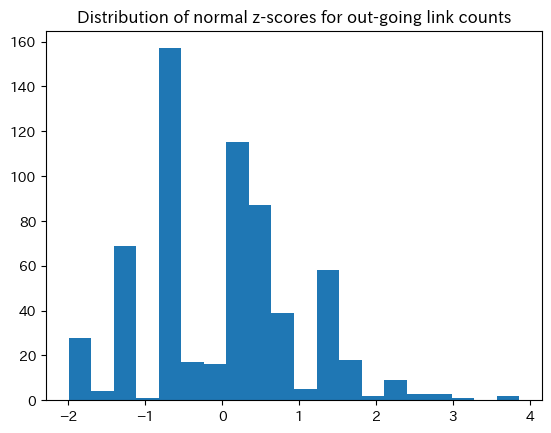

In [19]:
## check robust z-score distribution
import matplotlib.pyplot as plt
plt.hist(normal_zscores_from_s, bins = 20)
plt.title(f"Distribution of normal z-scores for out-going link counts")
plt.show()

In [ ]:
## calculate z-scores from link targets
if verbose:
    print(f"##Link_targets")

Link_targets     = M.link_targets
ranked_links     = plb.make_ranked_dict (Link_targets, gap_mark = gap_mark)
averages_by_rank = plb.calc_averages_by_rank (Link_targets, ranked_links) # returns dict
stdevs_by_rank   = plb.calc_stdevs_by_rank (Link_targets, ranked_links) # returns dict
medians_by_rank  = plb.calc_medians_by_rank (Link_targets, ranked_links) # returns dict
MADs_by_rank     = plb.calc_MADs_by_rank (Link_targets, ranked_links) # returns dict

## calculate z-scores
target_zscores = { }
robust_zscores_from_t  = [ ] # for inspection only
normal_zscores_from_t  = [ ] # for inspection only
for i, link_target in enumerate(Link_targets):
    rank     = plb.get_rank_of_list (link_target, gap_mark)
    value    = Link_targets[link_target]
    ## robust z-scores
    robust_zscore  = plb.calc_zscore (value,
                                      averages_by_rank[rank], stdevs_by_rank[rank], medians_by_rank[rank], MADs_by_rank[rank], robust = True)
    robust_zscores_from_t.append(robust_zscore)
    ## tracking z-scores
    normal_zscore   = plb.calc_zscore_old (value,
                                           averages_by_rank[rank], stdevs_by_rank[rank])
    normal_zscores_from_t.append(normal_zscore)
    if use_robust_zscore:
        target_zscores[link_target] = robust_zscore
    else:
        target_zscores[link_target] = normal_zscore
    if verbose:
        print(f"#target {i:3d}: {link_target} has {value} in-coming(s) [{target_zscores[link_target]: .4f} at rank {rank}]")

## attach source_zscores to M
M.target_zscores.update(target_zscores)

##Link_targets
#target 0: ('b', '…', '…') has 3 in-coming(s) [ 0.6745 at rank 1]
#target 1: ('…', 'u', '…') has 3 in-coming(s) [ 0.6745 at rank 1]
#target 2: ('…', '…', 'n') has 3 in-coming(s) [ 0.6745 at rank 1]
#target 3: ('d', '…', '…') has 3 in-coming(s) [ 0.6745 at rank 1]
#target 4: ('p', '…', '…') has 3 in-coming(s) [ 0.6745 at rank 1]
#target 5: ('…', 'i', '…') has 3 in-coming(s) [ 0.6745 at rank 1]
#target 6: ('…', '…', 'd') has 3 in-coming(s) [ 0.6745 at rank 1]
#target 7: ('b', 'u', '…') has 4 in-coming(s) [ 1.3490 at rank 2]
#target 8: ('b', '…', 'n') has 4 in-coming(s) [ 1.3490 at rank 2]
#target 9: ('…', 'u', 'n') has 4 in-coming(s) [ 1.3490 at rank 2]
#target 10: ('d', 'u', '…') has 4 in-coming(s) [ 1.3490 at rank 2]
#target 11: ('d', '…', 'n') has 4 in-coming(s) [ 1.3490 at rank 2]
#target 12: ('p', 'i', '…') has 4 in-coming(s) [ 1.3490 at rank 2]
#target 13: ('p', '…', 'n') has 4 in-coming(s) [ 1.3490 at rank 2]
#target 14: ('…', 'i', 'n') has 4 in-coming(s) [ 1.3490 a

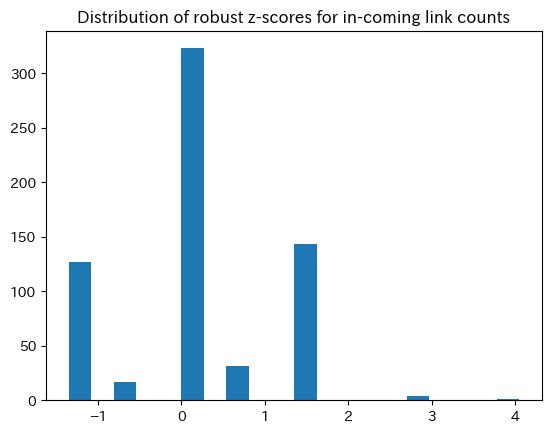

In [21]:
## check z-score distribution
import matplotlib.pyplot as plt
plt.hist(robust_zscores_from_t, bins = 20)
plt.title(f"Distribution of robust z-scores for in-coming link counts")
plt.show()

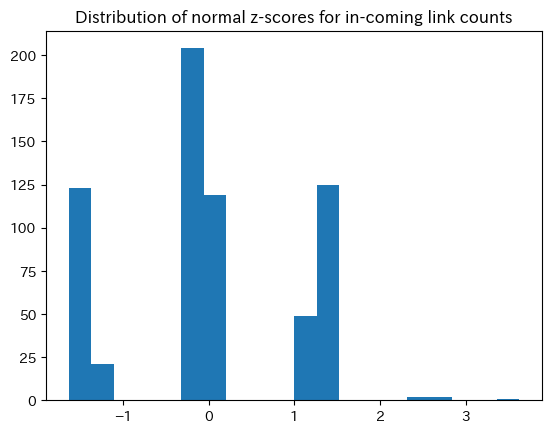

In [22]:
## check z-score distribution
import matplotlib.pyplot as plt
plt.hist(normal_zscores_from_t, bins = 20)
plt.title(f"Distribution of normal z-scores for in-coming link counts")
plt.show()

In [23]:
## select z-score base
if zscores_from_targets:
    Link_bases = M.target_zscores
    print(f"zscores are obtained from link_targets")
else:
    Link_bases = M.source_zscores
    print(f"zscores are obtained from link_sources")

zscores are obtained from link_sources


In [24]:

## check result
i = 0
for key, value in Link_bases.items():
    i += 1
    print(f"node {i:3d} {key} has z-score: {value: .4f}")

node   1 ('…', '…', '…') has z-score: -1.2647
node   2 ('b', '…', '…') has z-score: -1.0117
node   3 ('…', 'u', '…') has z-score: -0.6745
node   4 ('…', '…', 'n') has z-score: -0.3372
node   5 ('d', '…', '…') has z-score: -1.3490
node   6 ('p', '…', '…') has z-score: -1.3490
node   7 ('…', 'i', '…') has z-score: -1.3490
node   8 ('…', '…', 'd') has z-score: -1.3490
node   9 ('b', 'u', '…') has z-score: -1.3490
node  10 ('b', '…', 'n') has z-score: -2.0235
node  11 ('…', 'u', 'n') has z-score: -1.3490
node  12 ('d', 'u', '…') has z-score: -1.3490
node  13 ('d', '…', 'n') has z-score: -2.0235
node  14 ('…', 'u', 'd') has z-score: -1.3490
node  15 ('p', 'i', '…') has z-score: -2.0235
node  16 ('p', '…', 'n') has z-score: -2.0235
node  17 ('…', 'i', 'n') has z-score: -2.0235
node  18 ('b', '…', 'd') has z-score: -2.0235
node  19 ('…', '…', '…', '…') has z-score:  0.0000
node  20 ('b', '…', '…', '…') has z-score: -0.6745
node  21 ('…', 'b', '…', '…') has z-score: -0.6745
node  22 ('…', 'u',

pruned node ('b', 'u', 'n', 'n', '…') with z-score -0.6745
pruned node ('b', 'u', 'n', '…', 'y') with z-score -0.6745
pruned node ('b', 'u', '…', 'n', 'y') with z-score -0.6745
pruned node ('b', '…', 'n', 'n', 'y') with z-score -0.6745
pruned node ('…', 'u', 'n', 'n', 'y') with z-score -0.6745
pruned node ('b', 'u', 'm', 'p', '…') with z-score -0.6745
pruned node ('b', 'u', 'm', '…', 'y') with z-score -0.6745
pruned node ('b', 'u', '…', 'p', 'y') with z-score -0.6745
pruned node ('b', '…', 'm', 'p', 'y') with z-score -0.6745
pruned node ('…', 'u', 'm', 'p', 'y') with z-score -0.6745
pruned node ('p', 'i', 'n', 'k', '…') with z-score -0.6745
pruned node ('p', 'i', 'n', '…', 'y') with z-score -0.6745
pruned node ('p', 'i', '…', 'k', 'y') with z-score -0.6745
pruned node ('p', '…', 'n', 'k', 'y') with z-score -0.6745
pruned node ('…', 'i', 'n', 'k', 'y') with z-score -0.6745
pruned node ('b', 'u', 'n', 'n', 'y', '…') with z-score  0.0000
pruned node ('…', 'b', 'u', 'n', 'n', 'y', '…') wit

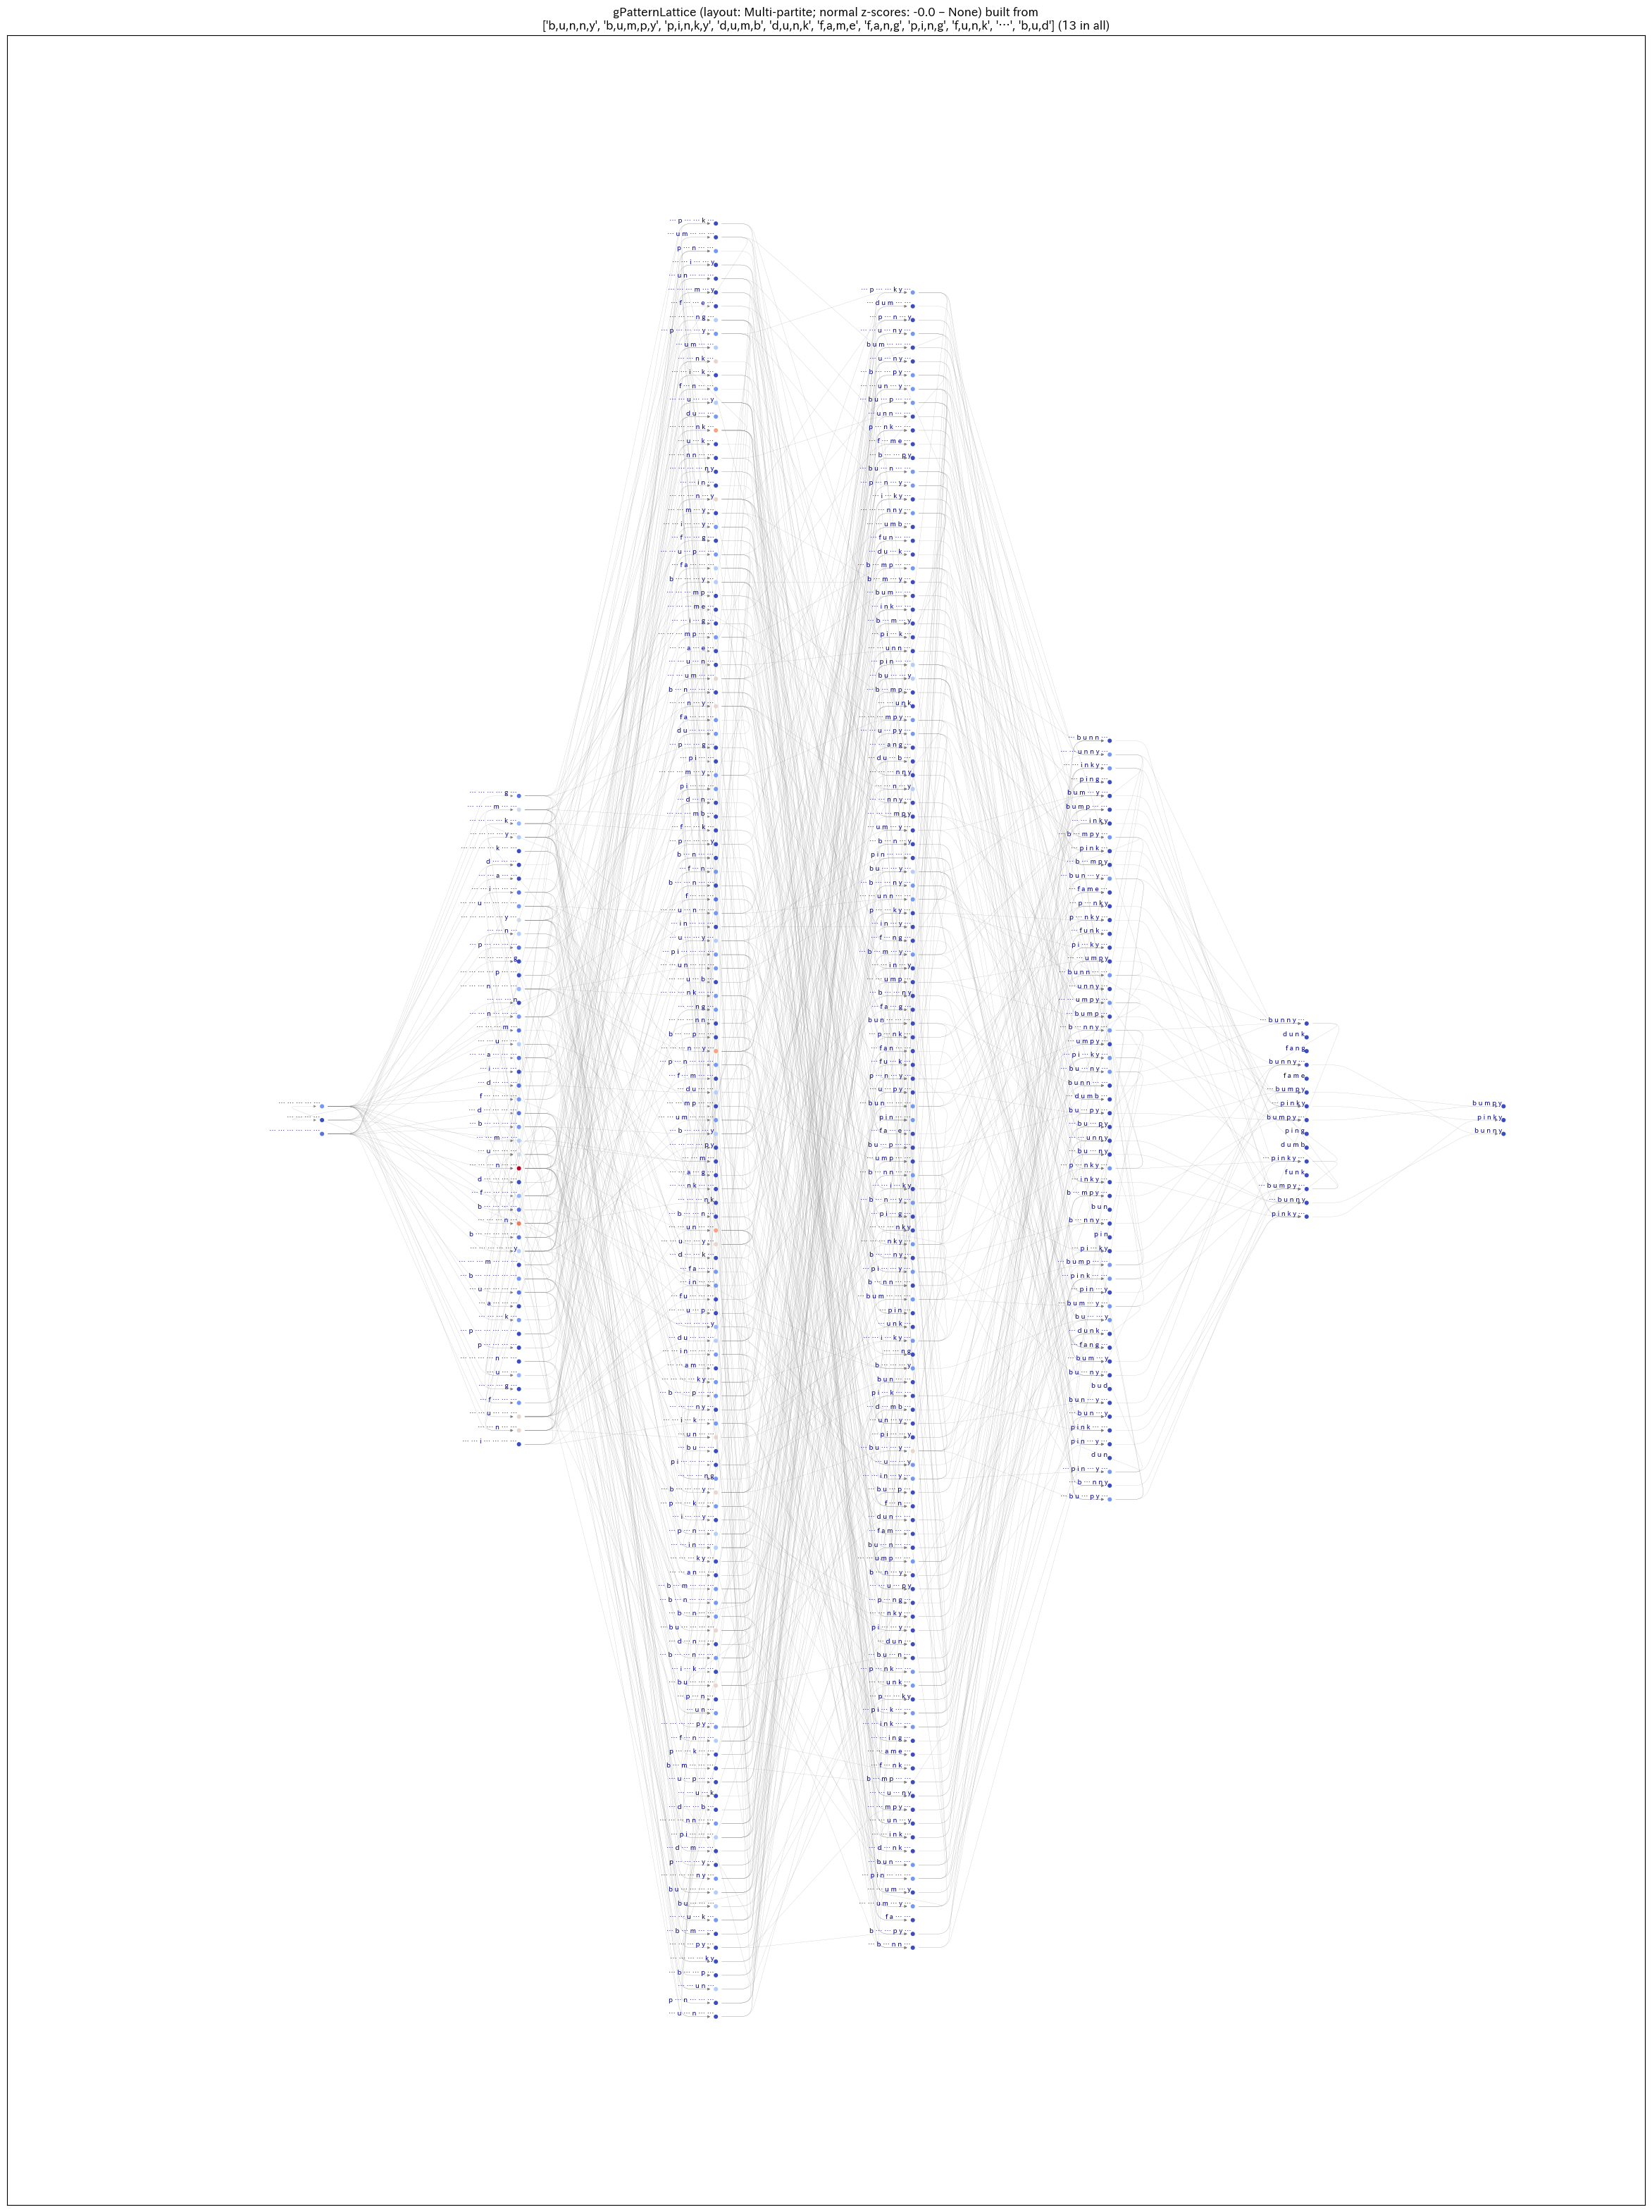

In [25]:
## draw a pruned diagram from the merged lattice
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'ARF', # 2
                    'Fruchterman_Reingold', # 3
                    'Kamada_Kawai', # 4
                    'Spring', # 5
                    'Shell', # 6
                    'Spectral', # 7
                    'Circular', # 8
                    'Planar' # 9 # often fails
                 ]
##
layout             = graph_layouts[0]
scale_factor       = 3
zscore_lowerbound  = -0.0
zscore_upperbound  = None

manually_set = True
if manually_set:
   M.draw_diagrams (generalized = generalized, zscores_from_targets = zscores_from_targets, layout = layout, auto_fig_sizing = False, fig_size = (30, 40), label_sample_n = 10, label_size = 16, node_size = 52, font_name = multibyte_font_name, zscore_lb = zscore_lowerbound, scale_factor = scale_factor, check = False)
else:
   M.draw_diagrams (generalized = generalized, zscores_from_targets = zscores_from_targets, layout = layout, auto_fig_sizing = True, label_sample_n = 4, zscore_lb = zscore_lowerbound, zscore_ub = zscore_upperbound, scale_factor = scale_factor, font_name = multibyte_font_name, check = False)

In [26]:
## draw a full diagram from the merged lattice
if draw_full_version_for_merged:
    layout = graph_layouts[0]
    zscore_lowerbound  = None
    scale_factor       = 3
    ##
    adjusted = False
    if adjusted:
        M.draw_diagrams (layout = layout, zscore_lowerbound = zscore_lowerbound,
        scale_factor = scale_factor, fig_size = (24, 60), label_size = 12, node_size = 33, font_name = multibyte_font_name, check = False)
    else:
        M.draw_diagrams (layout = layout, zscore_lowerbound = zscore_lowerbound,
        scale_factor = scale_factor, font_name = multibyte_font_name, check = False)